In [170]:
import pandas as pd
import numpy as np
import psycopg2 as pg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve
import gc
import xgboost as xgb
from xgboost import plot_tree
from feature_queries import *
from xgboost import plot_importance
from scipy.stats import percentileofscore
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns

pd.options.display.max_rows = 400

##Feature Queries + Setup DF

In [2]:
connection = pg.connect(open("creds").read())

In [3]:
base_q = "select dsysrtky from copd_2016;"
df_base = pd.read_sql_query(base_q, connection, index_col = 'dsysrtky')

In [4]:
period1_cond = "c.thru_dt < '2016-09-01'"
period2_cond = "c.thru_dt >= '2016-09-01' and c.thru_dt < '2017-01-01'"

In [5]:
#condition queries
cond_q1 = condition_query.format(cond=period1_cond)
df_cond1 = pd.read_sql_query(cond_q1, connection, index_col = 'dsysrtky')

cond_q2 = condition_query.format(cond=period2_cond)
df_cond2 = pd.read_sql_query(cond_q2, connection, index_col = 'dsysrtky')

In [6]:
#dme queries
dme_q1 = dme_query.format(cond=period1_cond)
df_dme1 = pd.read_sql_query(dme_q1, connection, index_col = 'dsysrtky')

dme_q2 = dme_query.format(cond=period2_cond)
df_dme2 = pd.read_sql_query(dme_q2, connection, index_col = 'dsysrtky')

In [7]:
#ip queries
ip_q1 = ip_query.format(cond=period1_cond)
df_ip1 = pd.read_sql_query(ip_q1, connection, index_col = 'dsysrtky')

ip_q2 = ip_query.format(cond=period2_cond)
df_ip2 = pd.read_sql_query(ip_q2, connection, index_col = 'dsysrtky')

In [8]:
#hha queries
hha_q1 = hha_query.format(cond=period1_cond)
df_hha1 = pd.read_sql_query(hha_q1, connection, index_col = 'dsysrtky')

hha_q2 = hha_query.format(cond=period2_cond)
df_hha2 = pd.read_sql_query(hha_q2, connection, index_col = 'dsysrtky')

In [9]:
#snf queries
snf_q1 = snf_query.format(cond=period1_cond)
df_snf1 = pd.read_sql_query(snf_q1, connection, index_col = 'dsysrtky')

snf_q2 = snf_query.format(cond=period2_cond)
df_snf2 = pd.read_sql_query(snf_q2, connection, index_col = 'dsysrtky')

In [10]:
#er queries
er_q1 = er_query.format(cond=period1_cond)
df_er1 = pd.read_sql_query(er_q1, connection, index_col = 'dsysrtky')

er_q2 = er_query.format(cond=period2_cond)
df_er2 = pd.read_sql_query(er_q2, connection, index_col = 'dsysrtky')

In [11]:
#outp queries
outp_q1 = outp_query.format(cond=period1_cond)
df_outp1 = pd.read_sql_query(outp_q1, connection, index_col = 'dsysrtky')

outp_q2 = outp_query.format(cond=period2_cond)
df_outp2 = pd.read_sql_query(outp_q2, connection, index_col = 'dsysrtky')

In [12]:
#provider queries
prov_q1 = prov_query.format(cond=period1_cond)
df_prov1 = pd.read_sql_query(prov_q1, connection, index_col = 'dsysrtky')

prov_q2 = prov_query.format(cond=period2_cond)
df_prov2 = pd.read_sql_query(prov_q2, connection, index_col = 'dsysrtky')

In [13]:
#mbsf query
mbsf_q = mbsf_query.format(cond="c.rfrnc_yr = 2016")
df_mbsf = pd.read_sql_query(mbsf_q, connection, index_col = 'dsysrtky')

In [14]:
df_cond = df_cond1.join(df_cond2, how='outer',lsuffix='_9m',rsuffix='_3m')
df_dme = df_dme1.join(df_dme2, how='outer',lsuffix='_9m',rsuffix='_3m')
df_ip = df_ip1.join(df_ip2, how='outer',lsuffix='_9m',rsuffix='_3m')
df_hha = df_hha1.join(df_hha2, how='outer',lsuffix='_9m',rsuffix='_3m')
df_er = df_er1.join(df_er2, how='outer',lsuffix='_9m',rsuffix='_3m')
df_outp = df_outp1.join(df_outp2, how='outer',lsuffix='_9m',rsuffix='_3m')
df_prov = df_prov1.join(df_prov2, how='outer',lsuffix='_9m',rsuffix='_3m')
df_snf = df_snf1.join(df_snf2, how='outer',lsuffix='_9m',rsuffix='_3m')

In [15]:
#er and ip days since need to take the min
df_ip['ip_days_since'] = df_ip[['ip_days_since_9m','ip_days_since_3m']].min(axis=1)
df_ip = df_ip.drop(columns=['ip_days_since_9m','ip_days_since_3m'])

df_er['er_days_since'] = df_er[['er_days_since_9m','er_days_since_3m']].min(axis=1)
df_er = df_er.drop(columns=['er_days_since_9m','er_days_since_3m'])

df_outp['aecopd_days_since'] = df_outp[['aecopd_days_since_9m','aecopd_days_since_3m']].min(axis=1)
df_outp = df_outp.drop(columns=['aecopd_days_since_9m','aecopd_days_since_3m'])

In [16]:
df_full = (df_base.join(df_cond,how = 'outer')
               .join(df_dme, how = 'outer')
               .join(df_ip, how = 'outer')
               .join(df_hha,how='outer')
               .join(df_er,how='outer')
               .join(df_outp,how='outer')
               .join(df_snf,how='outer')
               .join(df_mbsf,how='outer')
                .join(df_prov,how='outer',rsuffix='prov'))

In [17]:
#er_and ip days since fillna with 1000
df_full['ip_days_since'] = df_full['ip_days_since'].fillna(1000) 
df_full['er_days_since'] = df_full['er_days_since'].fillna(1000) 
df_full['aecopd_days_since'] = df_full['aecopd_days_since'].fillna(1000) 

df_full = df_full.fillna(0)

In [18]:
#delete old DFs to free memory
del df_cond1
del df_cond2
del df_dme1
del df_dme2
del df_ip1
del df_ip2
del df_hha1
del df_hha2
del df_er1
del df_er2
del df_snf1
del df_snf2
del df_outp1
del df_outp2
del df_cond
del df_dme
del df_ip
del df_hha
del df_er
del df_snf
del df_outp
del df_mbsf
gc.collect()

341

In [19]:
outcome_q = """
SELECT dsysrtky,MAX(aecopd_admit) as y
	FROM
	(SELECT s.dsysrtky,
	CASE WHEN i.admsn_dt >= '2017_01_01' AND i.admsn_dt < '2018-01-01' AND i.drg_cd in ('202','203','207','208','204','190','191','192','189','177','178','179') AND i.TYPE_ADM in ('1','2') AND UTIL_DAY > 0 THEN 1 ELSE 0 END as aecopd_admit
    FROM copd_2016 s 
	LEFT JOIN inp_claimsk i
	ON s.dsysrtky = i.dsysrtky)subq
GROUP BY dsysrtky
"""

df_o = pd.read_sql_query(outcome_q, connection, index_col = 'dsysrtky')

In [20]:
df_paid = pd.read_sql_query(paid_amt_query, connection, index_col = 'dsysrtky')

In [21]:
df_o = df_o.sort_index()
df_full = df_full.sort_index()

In [22]:
df_full['paid'] = df_paid['total_paid']

In [23]:
cols_dx = [col for col in list(df_full.columns) if 'dx' in col]
df_full[cols_dx] = np.minimum(df_full[cols_dx],20)

##High Level Data Explore

In [57]:
df_full.shape

(114204, 316)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(df_full, df_o['y'], test_size=0.2, random_state=42)

In [136]:
X_train.shape

(91363, 316)

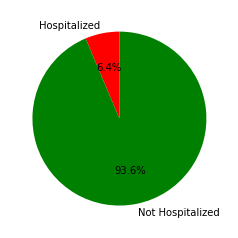

In [160]:
slices = [sum(df_o['y']==1), sum(df_o['y']==0)]
colors = ['r', 'g']
plt.pie(slices, labels=['Hospitalized', 'Not Hospitalized'], colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

In [164]:
corr = X_train.corr()

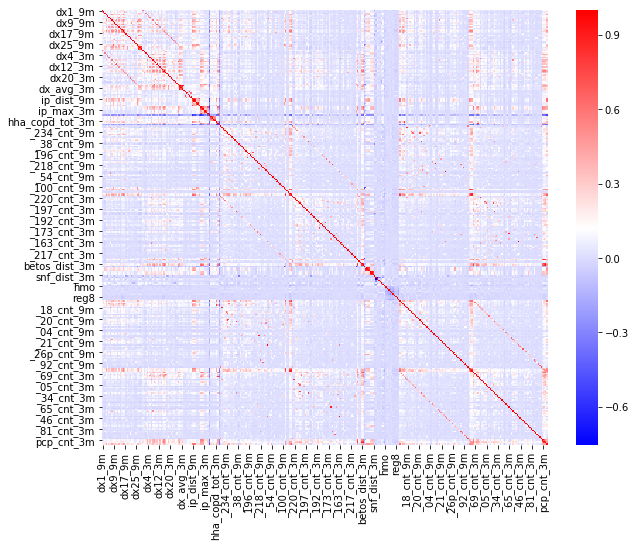

In [168]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,cmap='bwr')

In [137]:
selector = SelectKBest(f_classif, k=250)
selector.fit(X_train, y_train)

SelectKBest(k=250, score_func=<function f_classif at 0x7fe01ac3e6a8>)

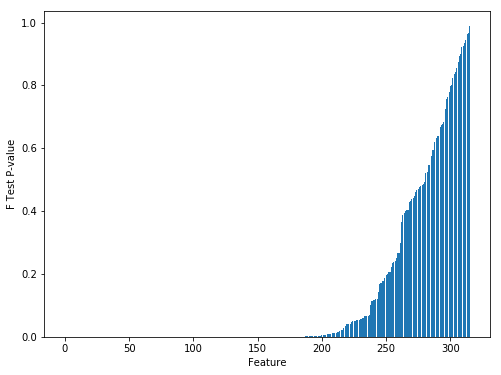

In [140]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(len(scores)),sorted(selector.pvalues_))
plt.ylabel("F Test P-value")
plt.xlabel("Feature")
plt.show()

In [139]:
selector.pvalues_[selector.get_support()==False]

array([0.48157295, 0.85547618, 0.39272354, 0.46019592, 0.48047428,
       0.59485531, 0.80112971, 0.90022647, 0.96698195, 0.26695891,
       0.2056874 , 0.4285607 , 0.47701489, 0.79706895, 0.59560331,
       0.23758477, 0.67848647, 0.93634342, 0.96433919, 0.49333442,
       0.44896266, 0.52211474, 0.46668942, 0.43239637, 0.98844333,
       0.84297465, 0.25175017, 0.6191969 , 0.63395222, 0.38703   ,
       0.48727407, 0.54729435, 0.40346895, 0.66873023, 0.9238068 ,
       0.2002163 , 0.43856924, 0.76195211, 0.83539643, 0.77961832,
       0.52423052, 0.47006673, 0.72587219, 0.39936862, 0.67421943,
       0.94310901, 0.57587549, 0.44312313, 0.20709949, 0.63831879,
       0.26674537, 0.89501788, 0.23602446, 0.19603207, 0.87432008,
       0.23985956, 0.82295071, 0.36373629, 0.54693428, 0.92272076,
       0.75756366, 0.68246263, 0.2217024 , 0.29764799, 0.63814748,
       0.40365049])

In [141]:
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

##Fit Classifiers

In [142]:
lr = LogisticRegression(penalty='l1',max_iter=5000)
lr.fit(X_train,y_train)

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [143]:
rfc = RandomForestClassifier(n_estimators=100,min_samples_leaf=50)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [144]:
xg = xgb.XGBClassifier()
eval_set  = [(X_train, y_train),(X_test, y_test)]
xg.fit(X_train, y_train, eval_set=eval_set,eval_metric="auc")


[0]	validation_0-auc:0.689495	validation_1-auc:0.686442
[1]	validation_0-auc:0.702491	validation_1-auc:0.697125
[2]	validation_0-auc:0.707845	validation_1-auc:0.702054
[3]	validation_0-auc:0.71523	validation_1-auc:0.707766
[4]	validation_0-auc:0.716041	validation_1-auc:0.708861
[5]	validation_0-auc:0.729869	validation_1-auc:0.72278
[6]	validation_0-auc:0.730205	validation_1-auc:0.722567
[7]	validation_0-auc:0.73067	validation_1-auc:0.723608
[8]	validation_0-auc:0.731769	validation_1-auc:0.724898
[9]	validation_0-auc:0.731766	validation_1-auc:0.725057
[10]	validation_0-auc:0.732081	validation_1-auc:0.725148
[11]	validation_0-auc:0.733283	validation_1-auc:0.726561
[12]	validation_0-auc:0.734258	validation_1-auc:0.727489
[13]	validation_0-auc:0.736363	validation_1-auc:0.728917
[14]	validation_0-auc:0.73637	validation_1-auc:0.729042
[15]	validation_0-auc:0.739752	validation_1-auc:0.731942
[16]	validation_0-auc:0.740049	validation_1-auc:0.731999
[17]	validation_0-auc:0.740732	validation_1-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [145]:
lr_pred = lr.predict_proba(X_test).T[1]
rf_pred = rfc.predict_proba(X_test).T[1]
xg_pred = xg.predict_proba(X_test).T[1]
preds = [X_test.T[-1],lr_pred,rf_pred,xg_pred]
model_labels = ['Paid','LR','RF','XGB']

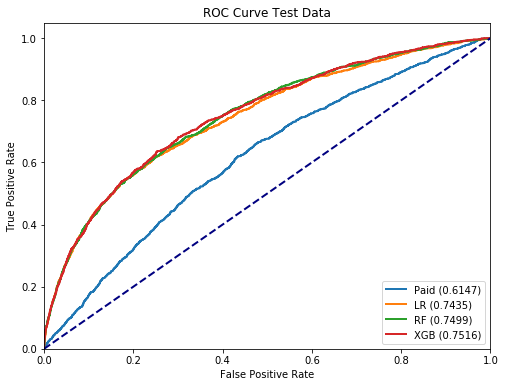

In [146]:
plt.figure(figsize=(8,6))
for i,pred in enumerate(preds):
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             lw=2, label='%s (%0.4f)' % (model_labels[i],roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Test Data')
plt.legend(loc="lower right")
plt.show()

In [147]:
lr_pred_t = lr.predict_proba(X_train).T[1]
rf_pred_t = rfc.predict_proba(X_train).T[1]
xg_pred_t = xg.predict_proba(X_train).T[1]
preds_t = [X_train.T[-1],lr_pred_t,rf_pred_t,xg_pred_t]

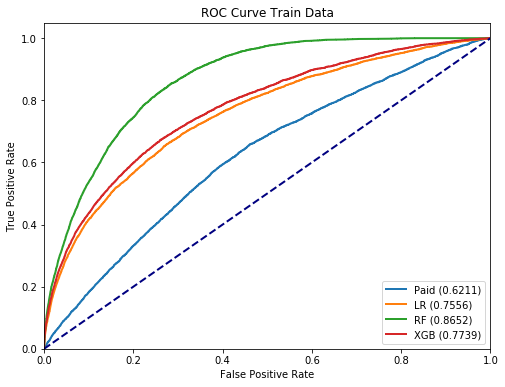

In [148]:
plt.figure(figsize=(8,6))
for i,pred in enumerate(preds_t):
    fpr, tpr, _ = roc_curve(y_train, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             lw=2, label='%s (%0.4f)' % (model_labels[i],roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Train Data')
plt.legend(loc="lower right")
plt.show()

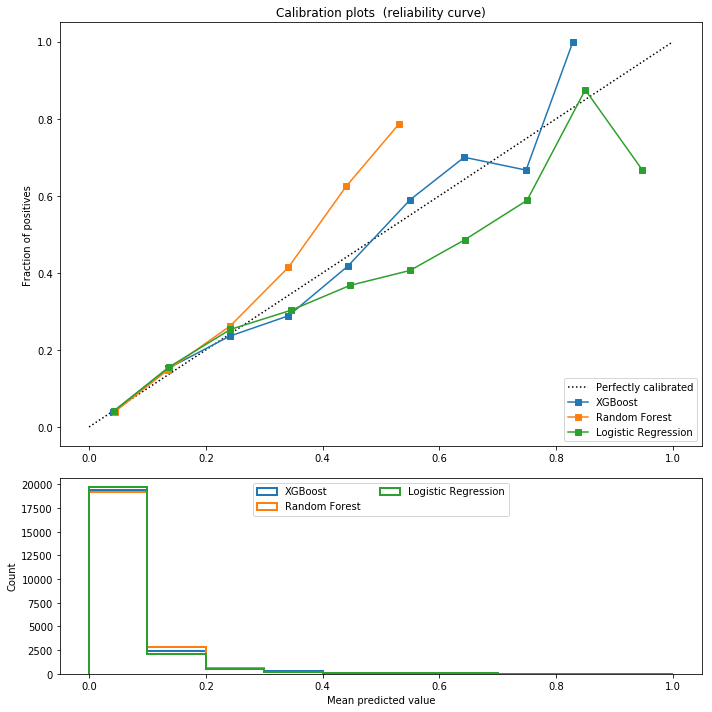

In [149]:
# Plot calibration plots
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(xg, 'XGBoost'),
                  (rfc, 'Random Forest'),
                    (lr,'Logistic Regression')]:
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [155]:
feature_importance_df = pd.DataFrame({'feat':np.array(df_full.columns)[selector.get_support()],
                                      'RF imp':rfc.feature_importances_,
                     'XGB imp':xg.feature_importances_})

In [156]:
feature_importance_df.sort_values(by=['XGB imp'],ascending=False).head(25)

,feat,RF imp,XGB imp
24,dx26_9m,0.060257,0.066822
8,dx9_9m,0.052326,0.055808
50,dx26_3m,0.049747,0.040259
35,dx9_3m,0.040468,0.035685
57,dme_dx2_3m,0.025585,0.024809
62,ip_copd_dist_9m,0.033814,0.023814
63,ip_copd_tot_9m,0.030682,0.023095
55,dme_dx2_9m,0.019198,0.022095
147,aecopd_days_since,0.033546,0.021417
69,ip_copd_tot_3m,0.031666,0.020904


In [154]:
labels = ['0-79','80-84','85-89','90-94','95+']
ts = [(0,80),(80,85),(85,90),(90,95),(95,100)]

print ("Percentile\t" + "\t\t".join(model_labels))
for i,l in enumerate(labels):
    l_t = ts[i][0]
    u_t = ts[i][1]
    props = []
    for pred in preds:
        cl = np.percentile(pred,l_t)
        cu = np.percentile(pred,u_t)
        y_temp = y_test[pred>=cl]
        p_temp = pred[pred>=cl]
        y_temp = y_temp[p_temp<cu]
        prop = y_temp.sum() / len(y_temp)
        props.append("%.4f" % prop)
    print("%s\t\t%s" % (labels[i],"\t\t".join(props)))

Percentile	Paid		LR		RF		XGB
0-79		0.0547		0.0365		0.0370		0.0364
80-84		0.0867		0.0954		0.0876		0.0946
85-89		0.0998		0.1243		0.1252		0.1322
90-94		0.1025		0.1716		0.1708		0.1664
95+		0.1042		0.2916		0.2916		0.2907


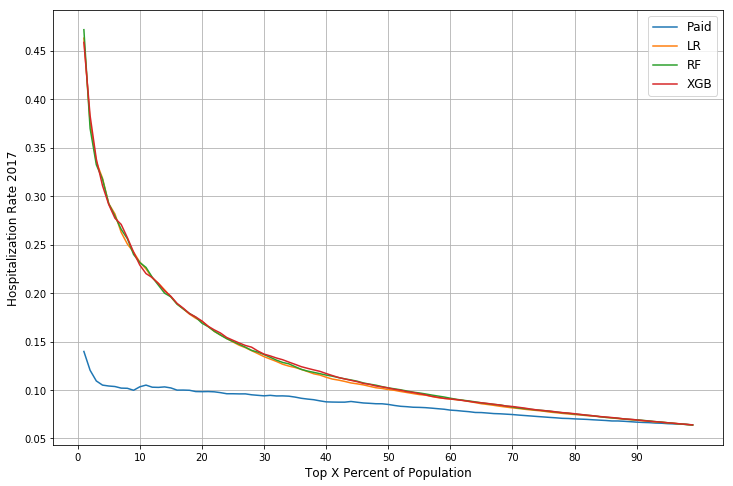

In [157]:
thresholds = np.arange(1,100,1)
pred_success = [[] for i in preds]
for t in thresholds:
    for ind,pred in enumerate(preds):
        pred_t = np.percentile(pred,100-t)
        pred_s = y_test[pred>=pred_t].sum() / y_test[pred>=pred_t].count()
        pred_success[ind].append(pred_s)

plt.figure(figsize=(12,8))
for i,v in enumerate(pred_success):
    plt.plot(thresholds,np.array(v),label=model_labels[i])
plt.xlabel('Top X Percent of Population',fontsize=12)
plt.ylabel('Hospitalization Rate 2017',fontsize=12)
plt.xticks(np.arange(0,100,10))
plt.legend(fontsize=12)
plt.grid()

In [158]:
#correlations
pd.DataFrame(np.array(preds).T.astype(float),columns=model_labels).corr()

,Paid,LR,RF,XGB
Paid,1.000000,0.262706,0.380828,0.288297
LR,0.262706,1.000000,0.880402,0.911520
RF,0.380828,0.880402,1.000000,0.949232
XGB,0.288297,0.911520,0.949232,1.000000


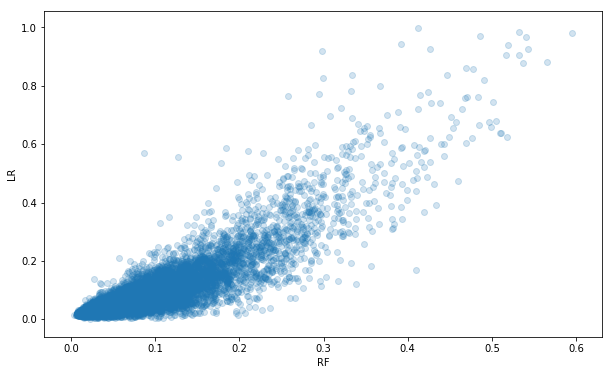

In [159]:
plt.figure(figsize=(10,6))
#plt.scatter(p,np.log1p(test_paid),alpha=.2)
plt.scatter(rf_pred,lr_pred,alpha=.2)
plt.xlabel("RF")
plt.ylabel("LR")
plt.show()

In [209]:
#preds = [X_test.T[-1],lr_pred,rf_pred,xg_pred]
print ("Model 1\tModel 2\tPerc\tJaccard")
for p in [5,10,20,30]:
    percentiles = []
    for pred in preds:
        percentiles.append(np.percentile(pred,100-p))
        
    for i in range(1,len(percentiles)-1):
        for j in range(i+1,len(percentiles)):
            i_in = preds[i] > percentiles[i]
            j_in = preds[j] > percentiles[j]

            jacc = sum(np.logical_and(np.logical_and(i_in,j_in),np.array(y_test > 0)))\
            / sum(np.logical_and(np.logical_or(i_in, j_in),np.array(y_test > 0)))
        
            print ("%s\t%s\t%d\t%.4f" % (model_labels[i],model_labels[j],p,jacc))



Model 1	Model 2	Perc	Jaccard
LR	RF	5	0.7015
LR	XGB	5	0.7235
RF	XGB	5	0.7713
LR	RF	10	0.7722
LR	XGB	10	0.7908
RF	XGB	10	0.8121
LR	RF	20	0.7954
LR	XGB	20	0.8196
RF	XGB	20	0.8633
LR	RF	30	0.8404
LR	XGB	30	0.8361
RF	XGB	30	0.9055


In [ ]:
#learning curve

In [175]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(lr, 
                                                        X_train, 
                                                        y_train,
                                                        cv=5,
                                                        scoring='roc_auc',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 25))

/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


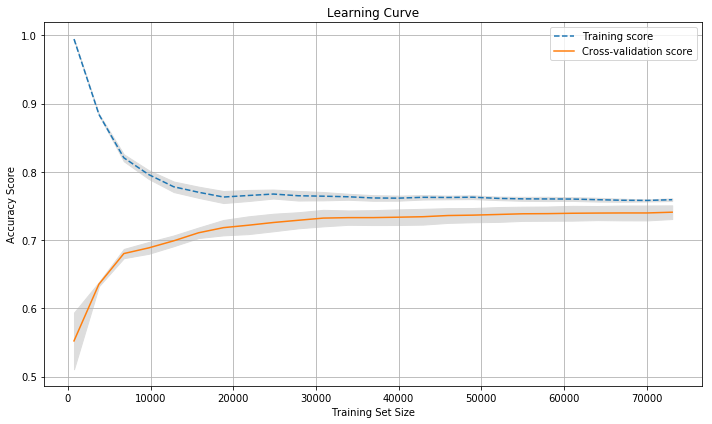

In [181]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
# Draw lines
plt.plot(train_sizes, train_mean, '--',  label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [182]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(rfc, 
                                                        X_train, 
                                                        y_train,
                                                        cv=5,
                                                        scoring='roc_auc',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 25))

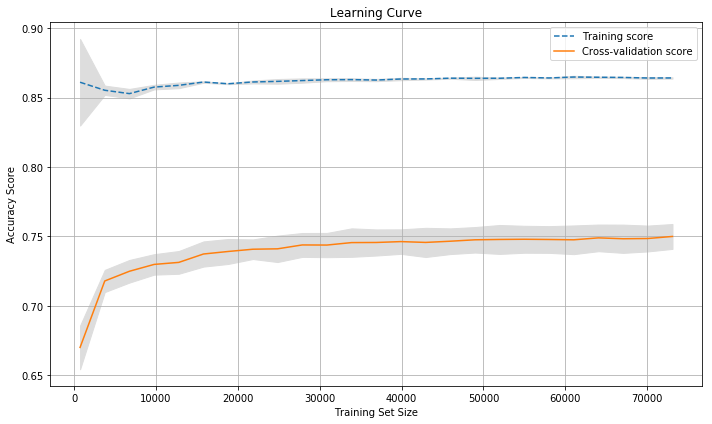

In [183]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
# Draw lines
plt.plot(train_sizes, train_mean, '--',  label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()